# Medical Image Segmentation. Traditional vs Deep Learning methods.

In this Practice, you will develop and train a convolutional neural network for brain tumour image segmentation
and compare the performance with respect to traditional methods for image segmentation.

When you train the network, it is recommended to use the GPU resources of your computer.
This will help you to learn the "know how" of setting up a working Python environment on your computer.

In the case of unavailable Nvidia hardware or problems with your Python environment you can use Google Colab.
Please go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware accelerator.


In [41]:
# Import libraries
# These libraries should be sufficient for this Practice.
# However, if any other library is needed, please install it by yourself.
import tarfile
import imageio.v2 as imageio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchsummary import summary

import sys
import numpy as np
import time
import os
import random

import matplotlib.pyplot as plt
from matplotlib import colors

## Download the imaging dataset

The dataset is curated from the brain imaging dataset in [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this practice, we extract 2D image slices from T1-Gd contrast enhanced 3D brain volumes and downsample the images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [42]:
# Download the dataset
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2023-06-22 17:50:25--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz [following]
--2023-06-22 17:50:25--  https://www.dropbox.com/s/raw/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7d5d47f59ab37258376a4e1621.dl.dropboxusercontent.com/cd/0/inline/B-fxfuIinFk2nPRINPgD5NmQ-JJkpu6C_0Yy5zIAkc03NqC2-l-FQ3bWXVyDQINRxIfiw3XU0tUSBPFve0QYdS7jwYFtFsYhVLOiRNxAEA7GJyWDu_fGw8XsoFuyEZne5qE7FF03LghL8NNre6a6RSELUhQfT9aBECLZ79wdNAI7IA/file# [following]
--2023-06-22 17:50:25--  https://uc7d5d47f59ab37258376a4e1621.dl.dropboxusercontent.com/cd/0/inline/B-fxfuIinFk2nPRINPgD5NmQ-JJkp

## Visualize the imaging dataset

Select a number of training and test images and visualize them in a grid to have an initial idea of the data.

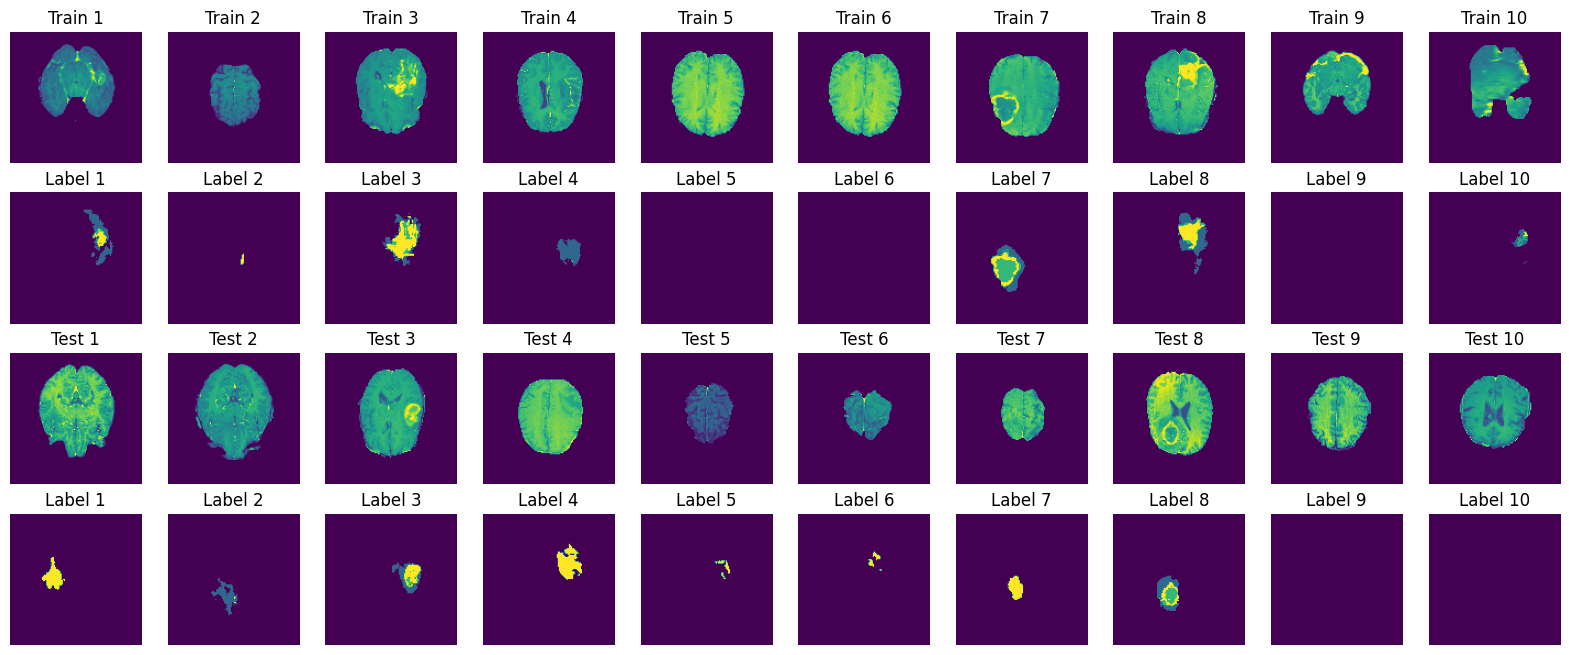

In [43]:
### Insert your code ###
# Set the paths for the training and test directories
train_dir   = 'Task01_BrainTumour_2D/training_images/'
test_dir    = 'Task01_BrainTumour_2D/test_images/'
train_label = 'Task01_BrainTumour_2D/training_labels/'
test_label  = 'Task01_BrainTumour_2D/test_labels/'

# Get a list of all the image filenames in the directories
train_files = os.listdir(train_dir)
test_files  = os.listdir(test_dir)

# Select 10 random training and test images
train_sample = random.sample(train_files, 10)
test_sample = random.sample(test_files, 10)

# Create a 2x10 grid of subplots for the images
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
# Loop through the training and test samples and display the images
for i, filename in enumerate(train_sample):
    img = plt.imread(train_dir + filename)
    label = plt.imread(train_label + filename)

    axes[0, i].imshow(img)
    axes[0, i].set_title('Train {}'.format(i+1))
    axes[0, i].axis('off')

    axes[1, i].imshow(label)
    axes[1, i].set_title('Label {}'.format(i+1))
    axes[1, i].axis('off')


for i, filename in enumerate(test_sample):
    img = plt.imread(test_dir + filename)
    label = plt.imread(test_label + filename)

    axes[2, i].imshow(img)
    axes[2, i].set_title('Test {}'.format(i+1))
    axes[2, i].axis('off')

    axes[3, i].imshow(label)
    axes[3, i].set_title('Label {}'.format(i+1))
    axes[3, i].axis('off')

# Show the plot
plt.show()
### End of your code ###

# Implement a dataset class

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [44]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):

        # Initialize self variables
        ### Insert your code ###
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []
        ### End of your code ###

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image. Use imageio.imread.
            ### Insert your code ###
            image = imageio.imread(image_path + image_name)
            ### End of your code ###

            self.images += [image]

            # Read the label map
            if not self.deploy:
                ### Insert your code ###
                label = imageio.imread(label_path + image_name)
                self.labels.append(label)
                ### End of your code ###


    def __len__(self): # Number of images
        ### Insert your code ###
        return self.images.size()
        ### End of your code ###


    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        ### Insert your code ###
        image = normalise_intensity(self.images[idx])
        ### End of your code ###

        # Get its label map
        # Dimension: XY
        ### Insert your code ###
        label = self.labels[idx]
        ### End of your code ###

        return image, label


    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        idx_sample = random.sample(list(range(len(self.images))), batch_size)
        for idx in idx_sample:
          images.append(self.images[idx])
          labels.append(self.labels[idx])
        ### End of your code ###

        images = np.array( images )

        images = np.expand_dims(images, axis = 1) #NCXY dimension, with C = 1

        labels = np.array( labels )

        return images, labels


# Build a U-net architecture

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.


In [45]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        n = num_filter  # 16
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),

            ### Insert your code ###
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
            ### End of your code ###
        )

        n *= 2  # 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),

            ### Insert your code ###
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
            ### End of your code ###
        )

        n *= 2  # 128
        self.conv4 = nn.Sequential(

            ### Insert your code ###
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
            ### End of your code ###
        )

        # Decoder path
        n = int(n / 2)  # 64
        self.up3 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_up3 = nn.Sequential(
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n = int(n / 2)  # 32
        self.up2 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_up2 = nn.Sequential(
            ### Insert your code ###
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
            ### End of your code ###
        )

        n = int(n / 2)  # 16
        self.up1 = nn.ConvTranspose2d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_up1 = nn.Sequential(
            ### Insert your code ###
            nn.Conv2d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
            ### End of your code ###
        )

        # Output
        self.out = nn.Conv2d(n, output_channel, kernel_size=1, padding=0)

    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.

        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)

        # Decoder
        x = self.up3(x)
        x = torch.cat([conv3_skip, x], dim = 1)
        x = self.conv_up3(x)

        ### Insert your code ###
        x = self.up2(x)
        x = torch.cat([conv2_skip, x], dim = 1)
        x = self.conv_up2(x)

        x = self.up1(x)
        x = torch.cat([conv1_skip, x], dim = 1)
        x = self.conv_up1(x)

        # Output
        x = self.out(x)
        ### End of your code ###

        return x

# Train the segmentation model

In [46]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
"""
- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour
"""
num_class = 4

model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

summary(model,(1,128,128))

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Adam Optimizer
### Insert your code ###
optimizer = torch.optim.Adam(params, lr=0.001)
### End of your code ###

# Segmentation loss. Criterion: Cross Entropy Loss.
### Insert your code ###
criterion = nn.CrossEntropyLoss()
### End of your code ###

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images/', 'Task01_BrainTumour_2D/training_labels/')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images/', 'Task01_BrainTumour_2D/test_labels/')
#train_set = BrainImageSet(train_dir, train_label)
#test_set = BrainImageSet(test_dir, test_label)

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16

start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a random batch of images and labels
    ### Insert your code ###
    images, labels = train_set.get_random_batch(train_batch_size)
    ### End of your code ###
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    logits = model(images)

    # Note that optimizer.zero_grad() is equivalent to net.zero_grad() if it optimises all the net parameters.
    optimizer.zero_grad()

    # Perform optimisation: compute the loss, backpropagation, and perform a step of your optimizer
    ### Insert your code ###
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    ### End of your code ###

    print('--- Iteration {0}: Training loss = {1:.4f}, {2:.4f} s ---'.format(it, loss.item(), time.time() - start_iter))

    # Evaluate
    if it % 10 == 0:
        model.eval()
        # Disabling gradient calculation during inference to reduce memory consumption
        with torch.no_grad():
            images, labels = test_set.get_random_batch(eval_batch_size)
            images, labels = torch.from_numpy(images), torch.from_numpy(labels)
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
            logits = model(images)
            loss = criterion(logits, labels)
            print('--- Iteration {0}: Test loss = {1:.4f} ---\n'.format(it, loss.item()))

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))

print('Training took {:.3f}s in total.'.format(time.time() - start))

Se han truncado las últimas 5000 líneas del flujo de salida.
--- Iteration 5836: Training loss = 0.0134, 0.0364 s ---
--- Iteration 5837: Training loss = 0.0119, 0.0365 s ---
--- Iteration 5838: Training loss = 0.0102, 0.0354 s ---
--- Iteration 5839: Training loss = 0.0145, 0.0361 s ---
--- Iteration 5840: Training loss = 0.0118, 0.0360 s ---
--- Iteration 5840: Test loss = 0.0284 ---

--- Iteration 5841: Training loss = 0.0104, 0.0355 s ---
--- Iteration 5842: Training loss = 0.0128, 0.0352 s ---
--- Iteration 5843: Training loss = 0.0092, 0.0366 s ---
--- Iteration 5844: Training loss = 0.0100, 0.0363 s ---
--- Iteration 5845: Training loss = 0.0129, 0.0366 s ---
--- Iteration 5846: Training loss = 0.0130, 0.0352 s ---
--- Iteration 5847: Training loss = 0.0215, 0.0356 s ---
--- Iteration 5848: Training loss = 0.0105, 0.0359 s ---
--- Iteration 5849: Training loss = 0.0085, 0.0357 s ---
--- Iteration 5850: Training loss = 0.0135, 0.0384 s ---
--- Iteration 5850: Test loss = 0.0531 -

# Visualise the segmentation results

In [47]:
# Get a random batch of test images
# Segment the images using the trained model
images, labels = test_set.get_random_batch(5)
images_torch, labels_torch = torch.from_numpy(images), torch.from_numpy(labels)
images_device, labels_device = images_torch.to(device, dtype=torch.float32), labels_torch.to(device, dtype=torch.long)
model.eval()
logits = model(images_device)
prob = F.softmax(logits, dim=1)
seg_unet = torch.argmax(prob, dim=1).cpu()

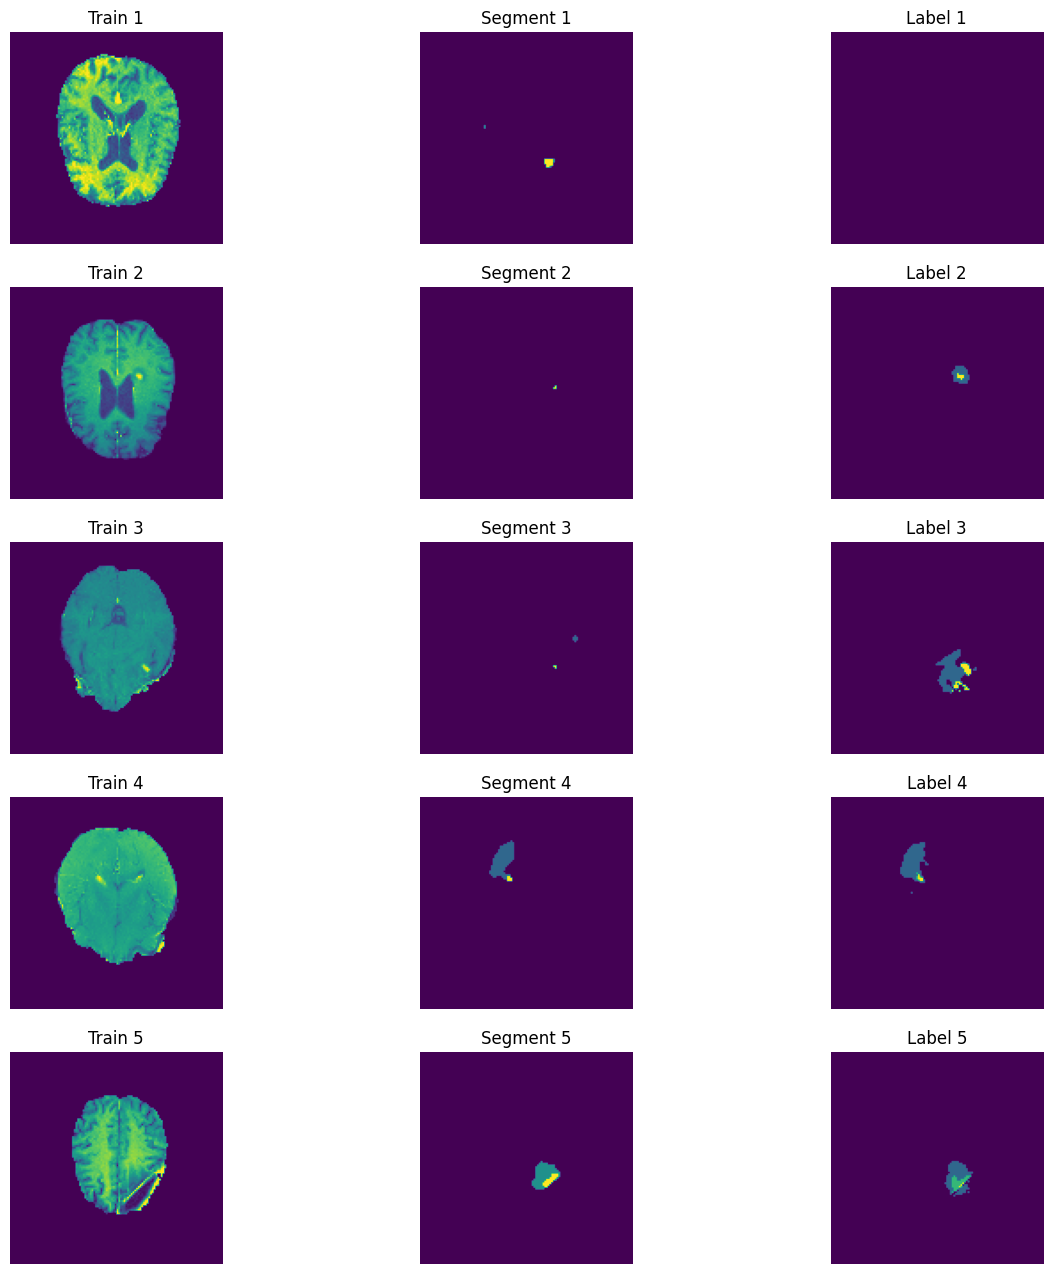

In [48]:
# Visualise the image, automated segmentation and manual segmentation
fig, axes = plt.subplots(5, 3, figsize=(15, 16))
### Insert your code ###
for i, image in enumerate(images):
    axes[i, 0].imshow(images[i].squeeze())
    axes[i, 0].set_title('Train {}'.format(i+1))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(seg_unet[i])
    axes[i, 1].set_title('Segment {}'.format(i+1))
    axes[i, 1].axis('off')

    axes[i, 2].imshow(labels[i].squeeze())
    axes[i, 2].set_title('Label {}'.format(i+1))
    axes[i, 2].axis('off')

plt.show()
### End of your code ###

## Evaluate the segmentation results

Use the Dice Similarity Coefficient (DSC) for the edema, non-enhancing tumour, enhancing tumour
Show boxplots of the similarity distribution on your test set


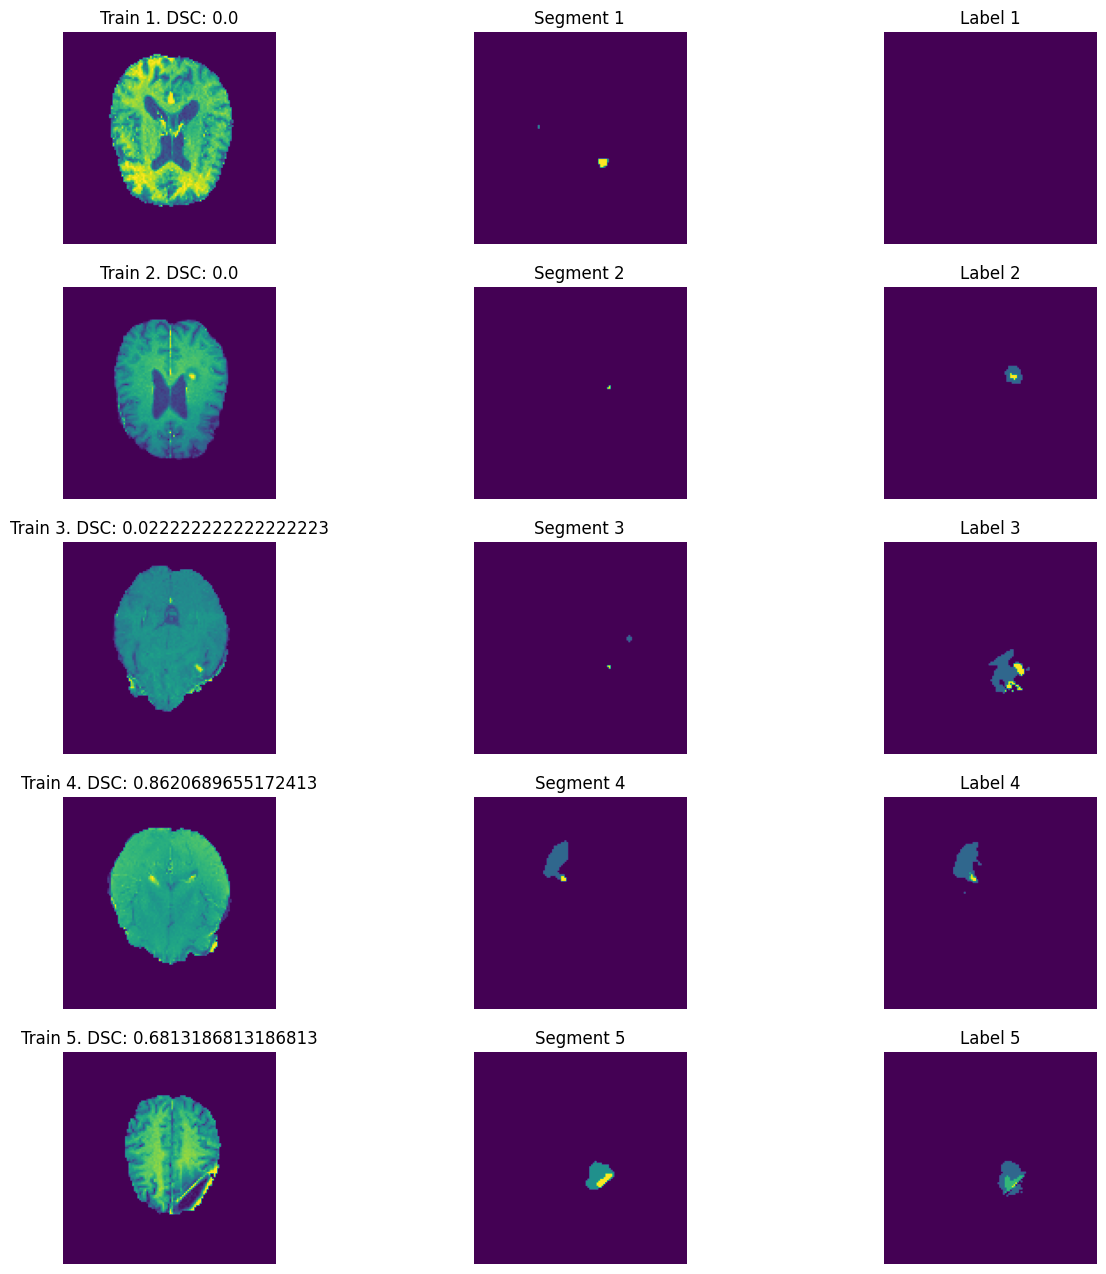

In [49]:
### Insert your code ###
def dsc(segment, label):
  pixels = np.count_nonzero(segment) + np.count_nonzero(label)
  if (pixels == 0):
    return pixels
  else:
    return 2*np.count_nonzero((label != 0) & (segment == label))/pixels

# Calculate DSC of each batch image
dsc_batch = np.zeros(len(seg_unet))
for i in range(0,5):
  dsc_batch[i] = dsc(np.array(seg_unet[i]), labels[i])

# Show results
fig, axes = plt.subplots(5, 3, figsize=(15, 16))
for i, image in enumerate(images):
    axes[i, 0].imshow(images[i].squeeze())
    axes[i, 0].set_title(f'Train {i+1}. DSC: {dsc_batch[i]}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(seg_unet[i])
    axes[i, 1].set_title('Segment {}'.format(i+1))
    axes[i, 1].axis('off')

    axes[i, 2].imshow(labels[i].squeeze())
    axes[i, 2].set_title('Label {}'.format(i+1))
    axes[i, 2].axis('off')

plt.show()

### End of your code ###

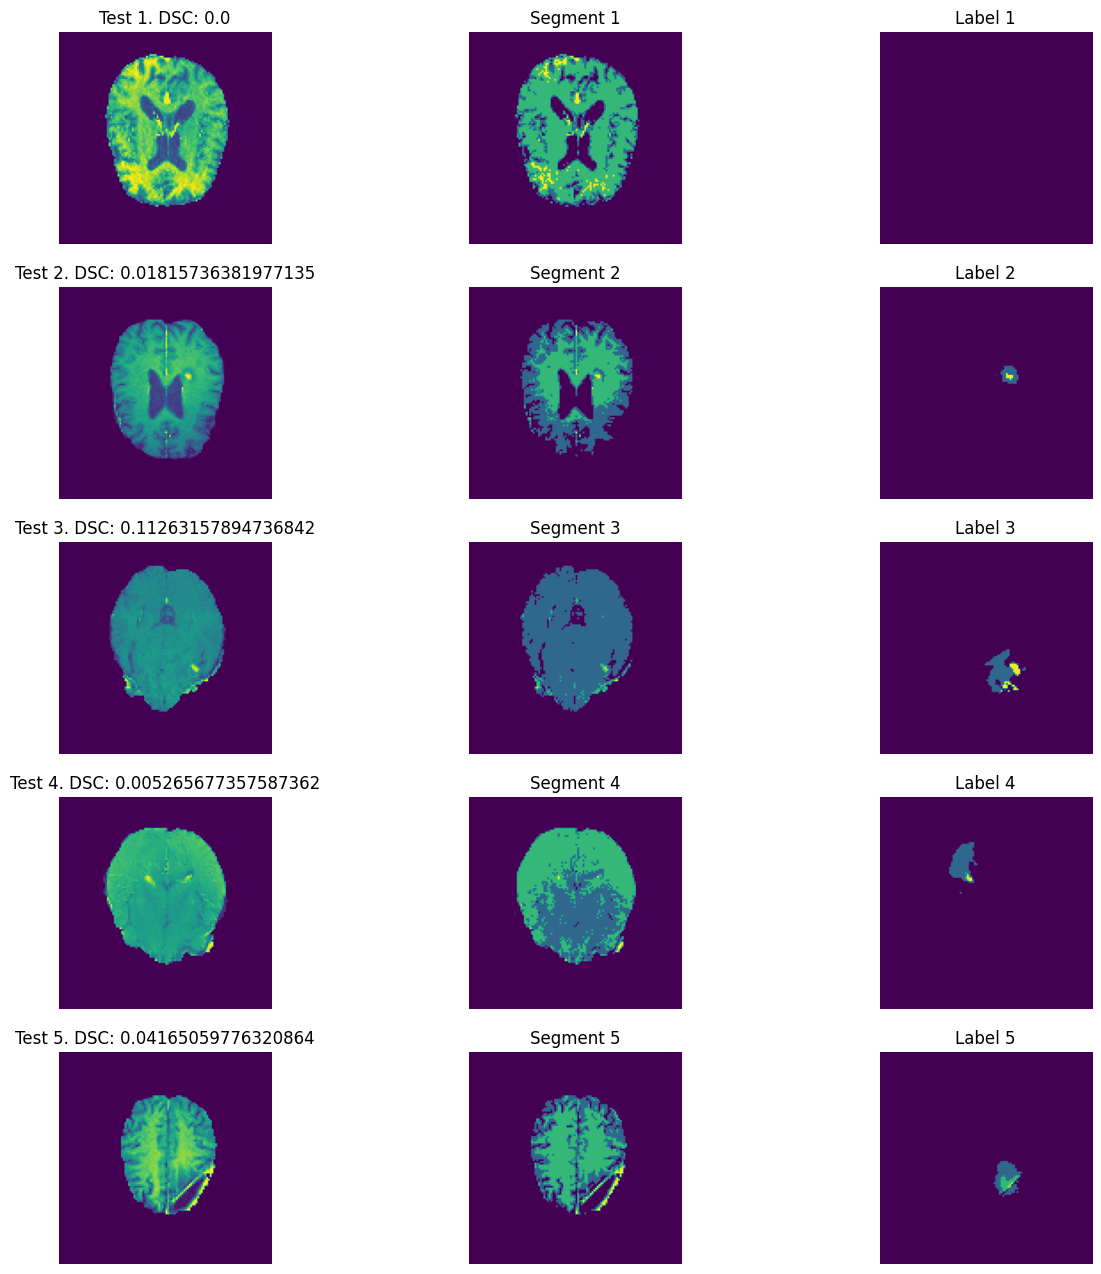

In [75]:
## Investigating traditional methods
# Select three images with low, medium, and high DSC score and try to segment
# the labels with traditional methods of your choice. Explain your conclusions
# in this notebook.
### Insert your code ###
def threshold(image, umbrals):
  return np.where(image <= umbrals[0], 0,
                  np.where(image <= umbrals[1], 1,
                           np.where(image <= umbrals[2], 2, 3)))

segments = []
for image in images:
  segments.append(threshold(image[0], [100, 150, 245]))

# Calculate DSC of each batch image
dsc_batch = np.zeros(len(segments))
for i in range(0,5):
  dsc_batch[i] = dsc(np.array(segments[i]), labels[i])

# Visualise the image, thresholding segmentation and manual segmentation
fig, axes = plt.subplots(5, 3, figsize=(15, 16))
for i, image in enumerate(images):
    axes[i, 0].imshow(images[i].squeeze())
    axes[i, 0].set_title(f'Test {i+1}. DSC: {dsc_batch[i]}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(segments[i])

    axes[i, 1].set_title('Segment {}'.format(i+1))
    axes[i, 1].axis('off')

    axes[i, 2].imshow(labels[i].squeeze())
    axes[i, 2].set_title('Label {}'.format(i+1))
    axes[i, 2].axis('off')

# Show the plot
plt.show()
### End of your code ###

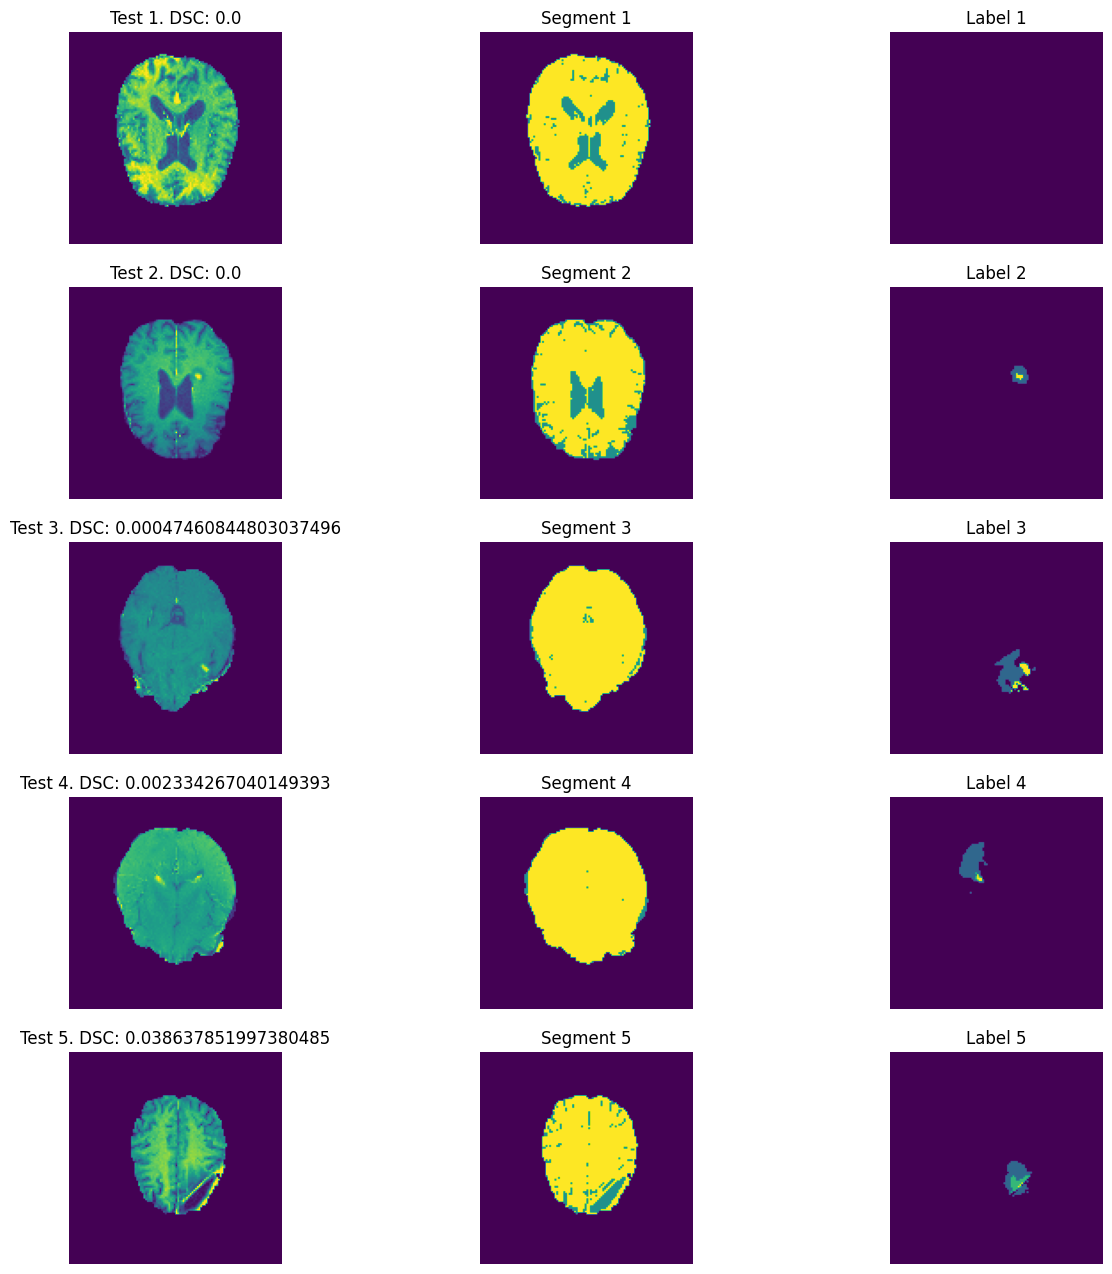

In [78]:
### Insert your code ###
def otsu_(image, h, LL, LH, i, k):
  best_sb_2  = 0
  best_thres = 0
  total      = image.shape[0]*image.shape[1]
  w0         = 0
  for t in range(LL, LH):
    w1 = total - w0
    if (w0 > 0 and w1 > 0):
      m0 = np.dot(range(t), h[:t]) / w0
      m1 = np.dot(range(t, LH), h[t:LH]) / w1
      sb_2 = w0 * w1 * (m0-m1) ** 2
      if sb_2 > best_sb_2:
        best_sb_2 = sb_2
        best_thres = t
    w0 += h[t]

  thres = [best_thres]
  if (i < k-1):
    if (best_thres > 0):
      thres = otsu_(image, h, 0, best_thres-1, i+2, k) + thres
    if (best_thres < 256):
      thres = thres + otsu_(image, h, best_thres+1, 256, i+2, k)
  return thres

def otsu(image, k):
  h, _  = np.histogram(image.flatten(), bins=range(257))
  thres = otsu_(image, h, 0, 256, 1, k)
  segment = np.zeros_like(image)
  for i in range(len(thres)):
    if i == 0:
        segment[image < thres[i]] = 0
    elif i < len(thres) - 1:
        segment[(image >= thres[i-1]) & (image < thres[i])] = i
    else:
        segment[image >= thres[i-1]] = i
  return segment

segments = []
for image in images:
  segments.append(otsu(image[0], 4))

# Calculate DSC of each batch image
dsc_batch = np.zeros(len(segments))
for i in range(0,5):
  dsc_batch[i] = dsc(np.array(segments[i]), labels[i])

# Visualise the image, thresholding segmentation and manual segmentation
fig, axes = plt.subplots(5, 3, figsize=(15, 16))
for i, image in enumerate(images):
    axes[i, 0].imshow(images[i].squeeze())
    axes[i, 0].set_title(f'Test {i+1}. DSC: {dsc_batch[i]}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(segments[i])

    axes[i, 1].set_title('Segment {}'.format(i+1))
    axes[i, 1].axis('off')

    axes[i, 2].imshow(labels[i].squeeze())
    axes[i, 2].set_title('Label {}'.format(i+1))
    axes[i, 2].axis('off')

# Show the plot
plt.show()
### End of your code ###

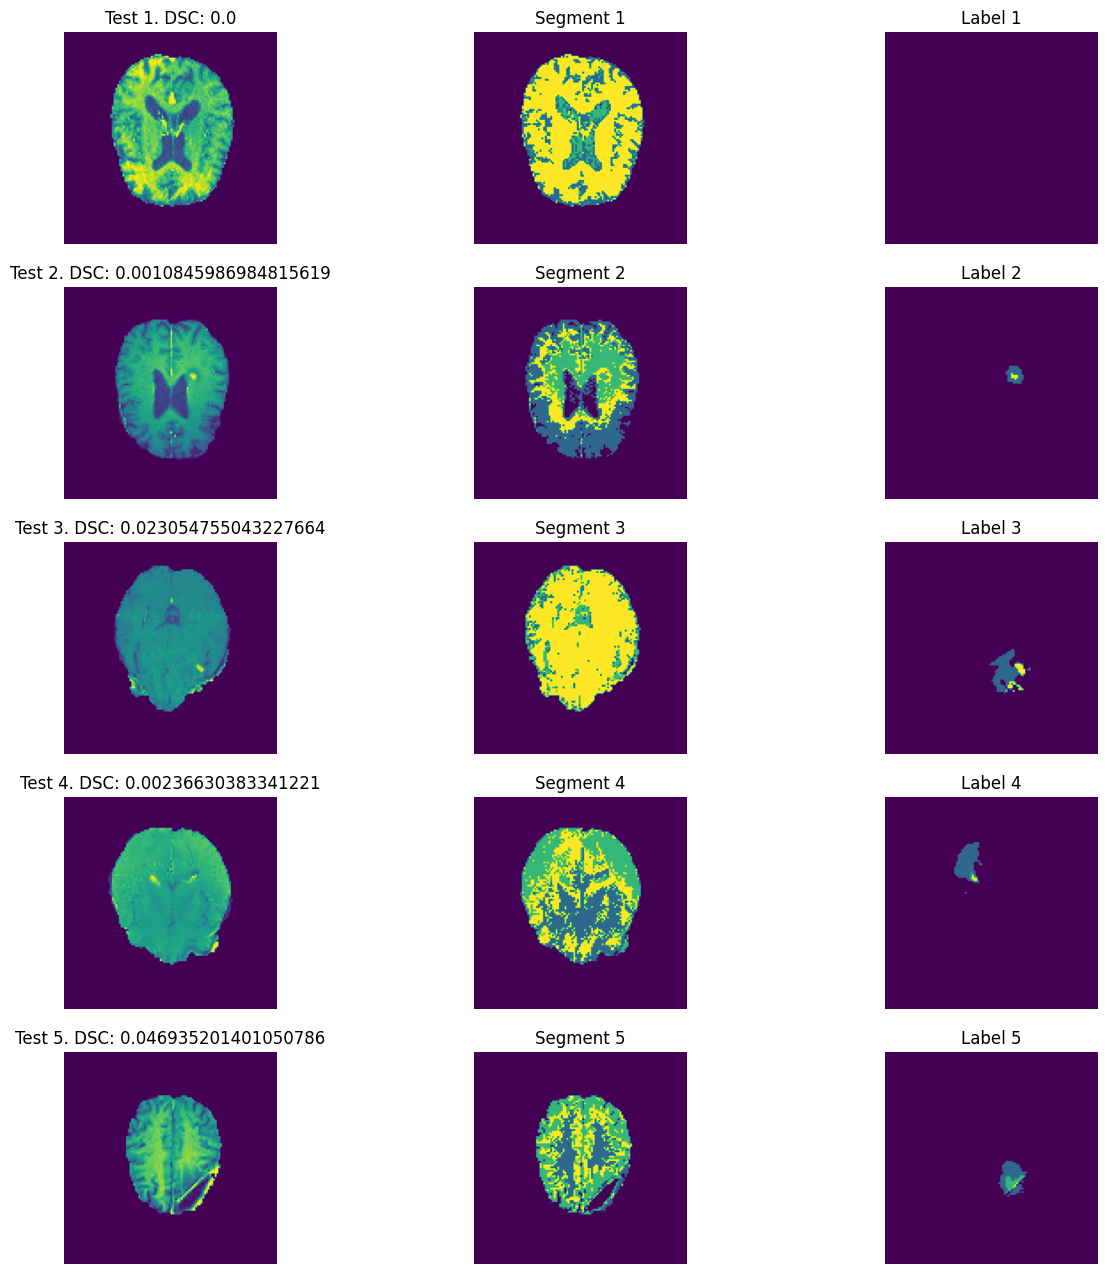

In [77]:
### Insert your code ###

def kmeans(image, k):
  origin = (image.shape[0]//2, image.shape[1]//2)
  mu  = np.zeros(k)
  c0  = np.zeros(image.shape)
  cf  = np.ones(image.shape)
  # Inicialización de los centroides
  # - Primer centroide
  mu[0] = 0
  # - Centroides restantes
  for i in range(1,k):
    x = random.randint(0, image.shape[0] - 1)
    y = random.randint(0, image.shape[1] - 1)
    while np.any(mu == image[x][y]) or \
      (x < (origin[0]-3*image.shape[0]//4) or x > (origin[0]+3*image.shape[0]//4)) or \
      (y < (origin[1]-image.shape[1]//2) or y > (origin[1]+image.shape[1]//2)):
      x = random.randint(0, image.shape[0] - 1)
      y = random.randint(0, image.shape[1] - 1)
    mu[i] = image[x][y]

  # Recalculo de los centroides
  while not np.array_equal(c0, cf):
    # Backup de los clusters en la iteración anterior
    cf = c0
    # Actualización de los clusters
    euc = np.zeros(k)
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        for l in range(k):
          euc[l] = np.linalg.norm(image[i][j] - mu[l])
        c0[i][j] = np.argmin(euc)
    # Recalculo de los centroides
    for i in range(k):
      points = np.argwhere(c0 == i)
      if (len(points) > 0):
        mu[i] = np.mean(image[points[:,0], points[:,1]])

  return c0, mu

segments = []
for image in images:
  c, _ = kmeans(image[0], 4)
  segments.append(c)

# Calculate DSC of each batch image
dsc_batch = np.zeros(len(segments))
for i in range(0,5):
  dsc_batch[i] = dsc(np.array(segments[i]), labels[i])

# Visualise the image, thresholding segmentation and manual segmentation
fig, axes = plt.subplots(5, 3, figsize=(15, 16))
for i, image in enumerate(images):
    axes[i, 0].imshow(images[i].squeeze())
    axes[i, 0].set_title(f'Test {i+1}. DSC: {dsc_batch[i]}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(segments[i])

    axes[i, 1].set_title('Segment {}'.format(i+1))
    axes[i, 1].axis('off')

    axes[i, 2].imshow(labels[i].squeeze())
    axes[i, 2].set_title('Label {}'.format(i+1))
    axes[i, 2].axis('off')

# Show the plot
plt.show()

### End of your code ###